## Training multi-fidelity neural networks for steady shear flows
The output of this notebook is the model's stored training, which is used to predict stress growth responses.

### Importing the dependencies

In [14]:
from time import time
from datetime import datetime
import os
import sys
import math
import tensorflow as tf
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
import itertools
import matplotlib.ticker as mticker
from matplotlib.pyplot import figure
import matplotlib.font_manager
from matplotlib import rc
from IPython.display import display

### Loading the Lo-Fi and Hi-Fi data
Similar to Lo-Fi data generation, it is possible to sample the Hi-Fi data and/or exclude flow curves as needed. We have two inputs (`Time` and `ShearRate`), while the output is the shear stress, `Stress`. The $\dot\gamma=1 s^{-1}$ stress growth test is masked, similar to Lo-Fi data generation notebook.

In [16]:
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
SEED=42
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

log10 = tf.experimental.numpy.log10
#Data
path = os.getcwd()
files = os.listdir(path)
df = {}
Shuffle = False

url_lf = 'https://github.com/procf/RhINNs/raw/main/MFNN/StressGrowth/Data_LF_SG.xlsx'
url_hf = 'https://github.com/procf/RhINNs/raw/main/MFNN/StressGrowth/Data_HF_SG.xlsx'
# url_lf, url_hf = 'Data_LF_SG.xlsx', 'Data_HF_SG.xlsx'

df_LF = pd.read_excel(url_lf, sheet_name=None)
data_LF = [[k,v] for k,v in df_LF.items()] #k is the sheet name, v is the pandas df

df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k,v] for k,v in df_HF.items()] #k is the sheet name, v is the pandas df

sample=0
data_HF[sample][1] = data_HF[sample][1].iloc[::5]

data_test = data_HF[sample][1]

#set reduction
# data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 0.05]
# data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 0.1]
# data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 0.5]
data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 1]
# data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 5]
# data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 10]
# data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 50]
# data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].SR != 100]


#LF
x1_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['Time'], dtype=DTYPE),(-1,1))
x2_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['ShearRate'], dtype=DTYPE), (-1,1))
y1_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['Stress'], dtype=DTYPE), (-1,1))

#HF
x1_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['Time'], dtype=DTYPE),(-1,1))
x2_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['SR'], dtype=DTYPE), (-1,1))
y1_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['Stress'], dtype=DTYPE), (-1,1))
y1_d_HF_std = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['StressSTD'], dtype=DTYPE), (-1,1))


x1_d_HF = np.log10(x1_d_HF)
x1_d_LF = np.log10(x1_d_LF)

x2_d_HF = np.log10(x2_d_HF)
x2_d_LF = np.log10(x2_d_LF)

y1_d_HF = np.log10(y1_d_HF)
y1_d_LF = np.log10(y1_d_LF)

x1min, x1max = np.min(x1_d_HF), np.max(x1_d_HF)
x2min, x2max = np.min(x2_d_HF), np.max(x2_d_HF)
lb = tf.constant([x1min, x2min], dtype=DTYPE).numpy()
ub = tf.constant([x1max, x2max], dtype=DTYPE).numpy()

X_data_HF = tf.concat([x1_d_HF, x2_d_HF], axis=1)
y_data_HF = tf.concat([y1_d_HF], axis=1)  

X_data_LF = tf.concat([x1_d_LF, x2_d_LF], axis=1)
y_data_LF = tf.concat([y1_d_LF], axis=1)  

Xy_data_HF = tf.concat([x1_d_HF, x2_d_HF, y1_d_HF], axis=1)
Xy_data_LF = tf.concat([x1_d_LF, x2_d_LF, y1_d_LF], axis=1)


if Shuffle:
    Xy_data_HF = tf.random.shuffle(Xy_data_HF)
    Xy_data_LF = tf.random.shuffle(Xy_data_LF)
    X_data_HF = Xy_data_HF[:,0:2]
    y_data_HF = Xy_data_HF[:,2:3]
    X_data_LF = Xy_data_LF[:,0:2]
    y_data_LF = Xy_data_LF[:,2:3]

in_dim, out_dim = 2, 1

### Defining the NN
Here, `PINN_NeuralNet` is a `tf.keras.Model` instance with several fully-connected layers.

In [17]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
            output_dim=out_dim,
            num_hidden_layers=4, 
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim

        self.lambd_list = []
    
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
    
    def call(self, X):
        """Forward-pass through neural network."""
        Z = X
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

### Modifying the NN training procedure
The functions `update_last_n_losses()` and `ES()` are defined to provide early stopping of training once the relative error in the last 20 iterations is not changing below a threshold, i.e., $5\times10^{-4}$.

The function `loss_fn()` provides the MFNN architecture and error heuristics; see the above image and follow along the `loss_fn()` lines. L2 norms are necessary to control overfitting and regularize the model.

The function `get_grad()` records the trainable variables of all three NNs, calculates the loss (`loss_frac` is just a sanity check to track loss components), takes the gradient of the loss w.r.t. the trainable variables, and return those gradients.

The function `train_step()` calls the `get_grad()` function, applies the optimizer to those gradients, and returns the loss.

Finally, a `for` loop with call the `train_step()` function for a set number of iterations (`N`). Note that the `max_relative_error` variable will terminate the training loop once the early stopping procedure is triggered.

The `callback()` is responsible for printing the loss values, while `plot_loss_history()` provides the loss history w.r.t. iterations.

In [18]:
class PINNSolver():
    def __init__(self, model_LF, model_HF_nl, model_HF_l):
        self.model_LF = model_LF
        self.model_HF_nl = model_HF_nl
        self.model_HF_l = model_HF_l
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        self.last_n_losses = []
        
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)
            
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    def loss_fn(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF):        
        y_pred_LF = self.model_LF(X_data_LF)
        y_pred_LF_HF = self.model_LF(X_data_HF)
        y_pred_HF_nl = self.model_HF_nl(tf.concat([X_data_HF, y_pred_LF_HF], axis=1))
        y_pred_HF_l = self.model_HF_l(tf.concat([X_data_HF, y_pred_LF_HF], axis=1))
        y_pred_HF = y_pred_HF_nl + y_pred_HF_l
        
        Loss_L2 = 1e-5*tf.add_n([tf.nn.l2_loss(w_) for w_ in self.model_HF_nl.trainable_weights])
        Loss_L2 += 1e-5*tf.add_n([tf.nn.l2_loss(w_) for w_ in self.model_LF.trainable_weights])
        Loss_data_LF = tf.reduce_mean(tf.square(y_data_LF - y_pred_LF))
        Loss_data_HF = tf.reduce_mean(tf.square(y_data_HF - y_pred_HF))
        
        loss = Loss_data_LF + Loss_data_HF + Loss_L2#
                
        loss_frac = [Loss_data_LF, Loss_data_HF, Loss_L2]
        return loss, loss_frac
    
    def get_grad(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model_LF.trainable_variables)
            tape.watch(self.model_HF_nl.trainable_variables)
            tape.watch(self.model_HF_l.trainable_variables)
            
            loss, loss_frac = self.loss_fn(X_data_LF, X_data_HF, y_data_LF, y_data_HF)            
        g_LF = tape.gradient(loss, self.model_LF.trainable_variables)
        g_HF_nl = tape.gradient(loss, self.model_HF_nl.trainable_variables)
        g_HF_l = tape.gradient(loss, self.model_HF_l.trainable_variables)
        del tape        
        return loss, g_LF, g_HF_nl, g_HF_l, loss_frac
    
    def solve_with_TFoptimizer(self, optimizer, X_data_LF, X_data_HF, y_data_LF, y_data_HF, N=1001):
        """This method performs a gradient descent type optimization."""        
        @tf.function
        def train_step():
            loss, g_LF, g_HF_nl, g_HF_l, loss_frac = self.get_grad(X_data_LF, X_data_HF, y_data_LF, y_data_HF)            
            optimizer.apply_gradients(zip(g_LF, self.model_LF.trainable_variables))
            optimizer.apply_gradients(zip(g_HF_nl, self.model_HF_nl.trainable_variables))
            optimizer.apply_gradients(zip(g_HF_l, self.model_HF_l.trainable_variables))
            return loss, loss_frac
        
        for i in range(N):          
            loss, loss_frac = train_step()
            self.loss_frac = loss_frac
            self.current_loss = loss.numpy()
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            if self.max_relative_error < 5e-4: # in %
                tf.print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break
        
    def callback(self, xr=None):
        if self.iter % 10000 == 0:
            tf.print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist.append(self.current_loss)
        self.iter+=1
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        return ax

### Instantiating the NNs and the solver
Here, the Lo-Fi, the nonlinear Hi-Fi, and the linear Hi-Fi NNs are instantiated from the `PINN_NeuralNet()` class. There are then built with their specified input shapes. We had `n=2`, which is `in_dim` in the below cell. We also have a 1-D output, which is shear stress. Therefore, the Lo-Fi NN takes `in_dim=2`-D inputs and spits `out_dim=1`-D output. Then, the nonlinear Hi-Fi NN lifts the `out_dim=1`-D Lo-Fi output + its own inputs, which are `in_dim=2`-D; same thing for the nonlinear Hi-Fi data. That's why the Hi-Fi NNs accept `in_dim+out_dim`-D inputs.

In [19]:
CMC = 1
model_LF = PINN_NeuralNet(output_dim=out_dim,
                          num_hidden_layers=4,
                          num_neurons_per_layer=20)
model_HF_nl = PINN_NeuralNet(output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=20)
model_HF_l = PINN_NeuralNet(output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')

model_LF.build(input_shape=(None,in_dim))
model_HF_nl.build(input_shape=(None,in_dim+out_dim))
model_HF_l.build(input_shape=(None,in_dim+out_dim))

solver = PINNSolver(model_LF, model_HF_nl, model_HF_l)
if 'runtime' in globals():
    del runtime

### MFNN training
We almost have everything by now. Next, we will instantiate the optimizer from `tf.keras.optimizers.legacy.Adam` with a specified learning rate. A piecewise learning rate is also provided. Then, the optimizer is called on `solver` with appropriate datasets.

In [20]:
mode = 'TFoptimizer'

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([20000,40000],[1e-2,2e-3,1e-3])
lr = 1e-3
N=5e4+1

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'TFoptimizer':
    try:
        t0 = time()
        optim = tf.keras.optimizers.legacy.Adam(learning_rate = lr)
        solver.solve_with_TFoptimizer(optim, X_data_LF, X_data_HF, y_data_LF, y_data_HF, N=int(N))
        runtime += (time()-t0)/60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time()-t0)/60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

It 0,000: Loss = 6.5734e+00, Max. rel. error = 100 %
It 10,000: Loss = 1.8183e-03, Max. rel. error = 0.34 %
It 20,000: Loss = 1.4430e-03, Max. rel. error = 75.31 %

Runtime: 0.793 minutes


### Visualizing the results

<Axes: xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

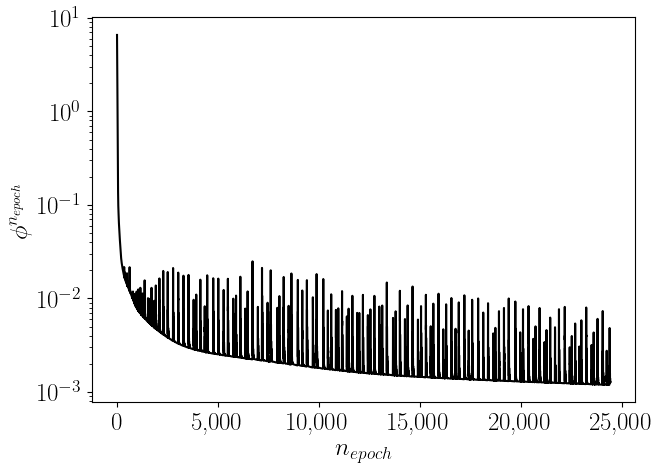

In [21]:
solver.plot_loss_history()

### Plotting the stress growth tests
Here, MFNN is called for all shear rates in `data_test`, which is the Hi-Fi data before the exclusion step. Hollow symbols are entirely masked during the Lo-Fi data generation and MFNN training. The same notation is used for other flow protocols.

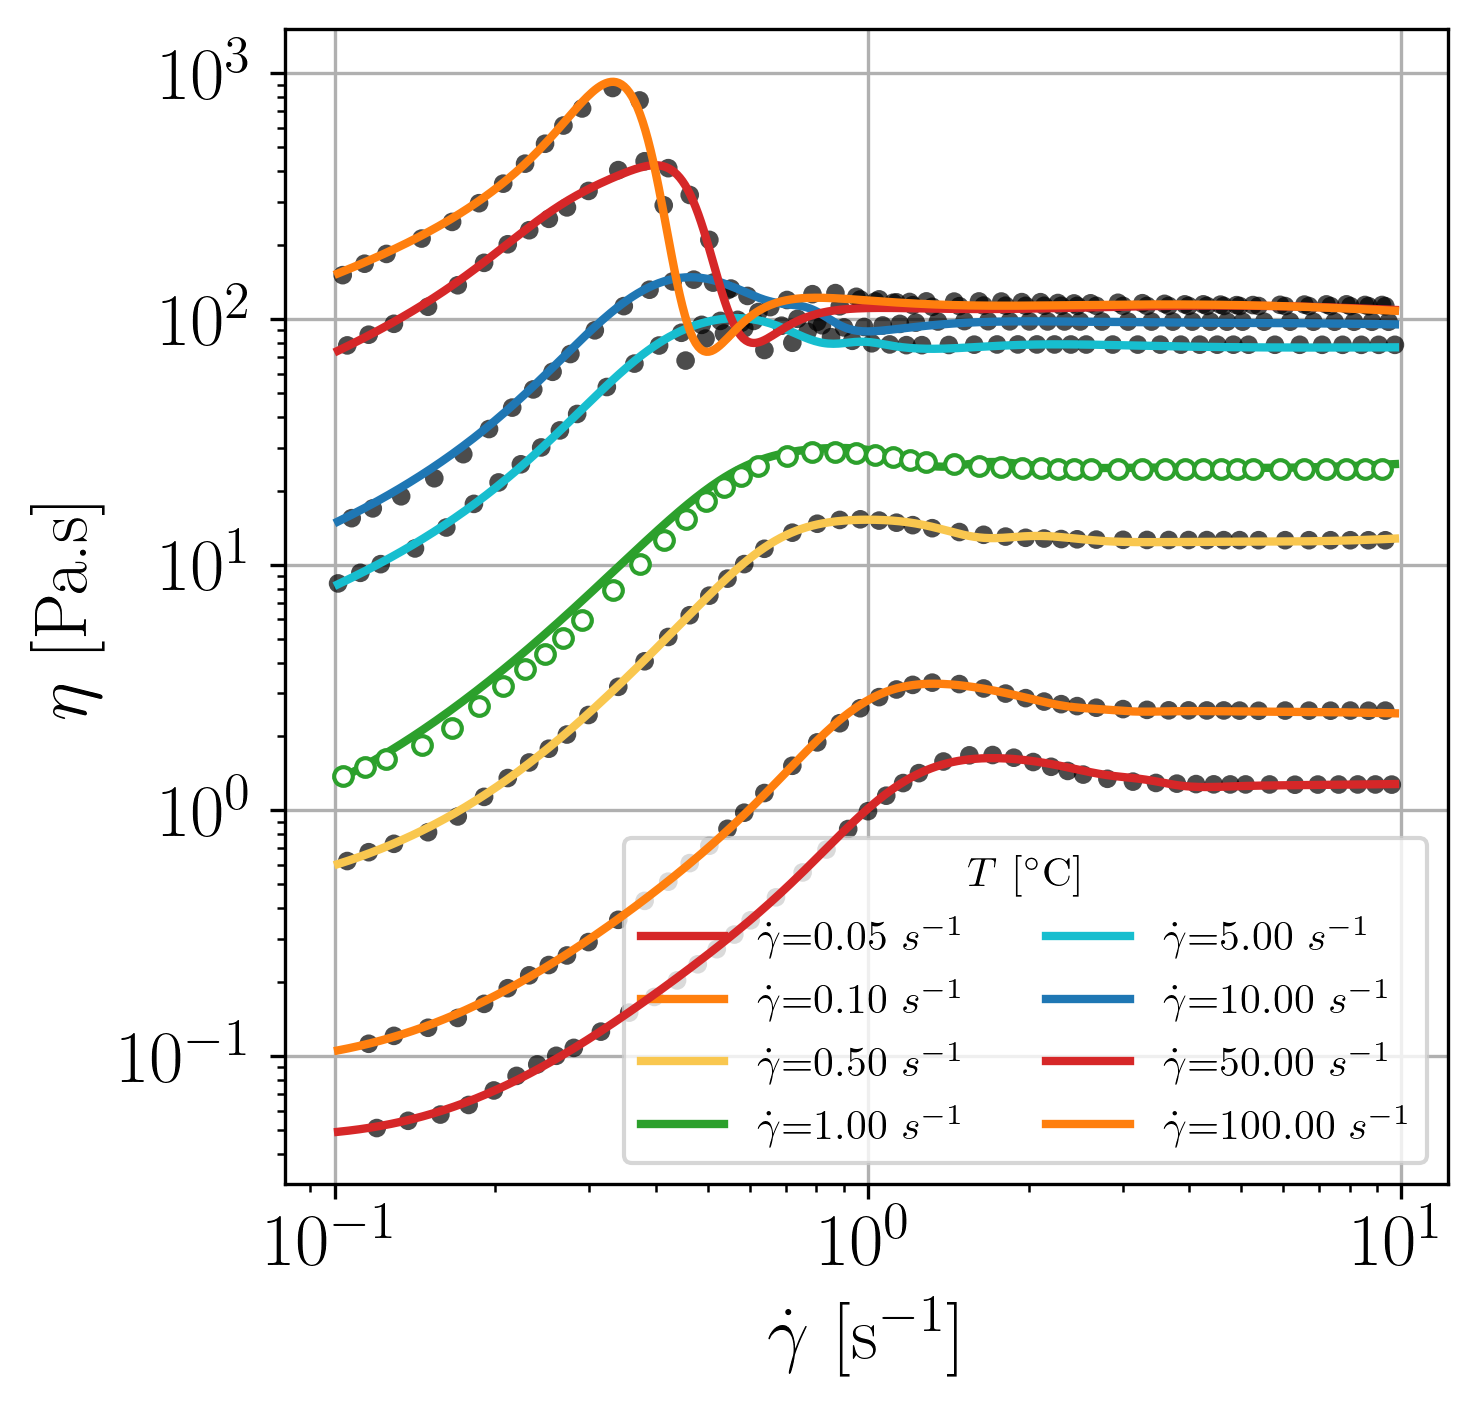

In [22]:
rc('font', **{'family': 'Times New Roman', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)

n_tests = 9
colors = plt.cm.jet(np.linspace(.2, 0.9, n_tests))
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue',
         'tab:red', 'tab:orange']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

Time_HF, SR_HF, Stress_HF = Xy_data_HF[:, 0], Xy_data_HF[:, 1], Xy_data_HF[:, 2]

N_exp = 400
Time_plot = np.linspace(np.min(Time_HF), np.max(Time_HF), N_exp).reshape(-1, 1)
SR = np.unique(data_test.SR)
i = 0
Time_pred = []
SR_pred = []
Stress_pred = []

for items in SR:
    x1_test = data_test[data_test.SR == items]['Time']
    x2_test = data_test[data_test.SR == items]['SR']
    y1_test = data_test[data_test.SR == items]['Stress']
    y1_test_std = data_test[data_test.SR == items]['StressSTD']

    
    SR_plot = np.log10(items) * np.ones(N_exp).reshape(-1, 1)
    X_LF = tf.concat([Time_plot, SR_plot], axis=1)
    y_LF = model_LF(X_LF)
    X_MF = np.column_stack((X_LF, y_LF))
    y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)

    ax.plot(10 ** Time_plot, 10 ** y_MF,
            label="$\dot{{\gamma}}$={:.2f} $s^{{-1}}$".format(items),
            lw=2., color=colors[i], alpha=1., zorder=10)



    if np.log10(items) in np.unique(x2_d_HF):
        ax.scatter(x1_test, y1_test,
                   s=20, color='k', zorder=2, alpha=0.7, edgecolors='none')

    else:
        ax.scatter(x1_test, y1_test, color=colors[i],
                   alpha=1., zorder=10, s=20, marker='o', lw=1., facecolors='white', edgecolors=colors[i])
    i += 1
    ax.set_xscale('log')
    ax.set_yscale('log')

    Time_pred = np.append(Time_pred, Time_plot)
    SR_pred = np.append(SR_pred, SR_plot)
    Stress_pred = np.append(Stress_pred, y_MF)

    legend = ax.legend(ncol=2, loc='best', title='$T$ [$\mathrm{^\circ C}$]', fontsize=10)
    plt.setp(legend.get_title(), fontsize=10)

ax.set_ylabel('$\eta$ [Pa.s]')
ax.set_xlabel('$\dot{\gamma}$ [$\mathrm{s^{-1}}$]')
ax.grid()

# plt.savefig("datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_FS.png", bbox_inches='tight', dpi=600)
plt.show()
